In [1]:
%load_ext autoreload
%autoreload 2

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import mols2grid

from rdkit import Chem

from src.utils import smi2mol
from src.config import mem
from mordred import Calculator, descriptors

In [150]:
train = pd.read_csv('../data/processed/train.csv')
train['rdmol'] = train.smi.apply(smi2mol)

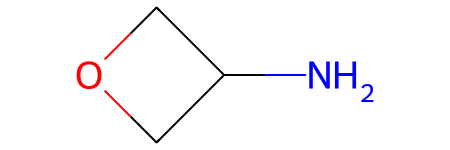

In [151]:
mol = smi2mol('NC1COC1')
mol

In [152]:
from src.fingerprints import get_fingerprints
from src.descriptors import get_rd_descriptors, get_md_descriptors
from src.representation import get_representation

def get_representation(smiles: str, config=None) -> pd.Series | None:
    """
    This function computes the vector representation for a single molecule
    Representation consists of stacked vectors of fingerprints and rdkit descriptors in the following order:
     - morgan fingerprints, size MORGAN_FP_SIZE, radius MORGAN_RADIUS
     - avalon fingerprints, size AVALON_FP_SIZE
     - erg fingerprints, size ERG_FP_SIZE
     - rdkit descriptors, size RD_DESCS_SIZE
    """

    mol = Chem.MolFromSmiles(smiles)
    if not smiles or mol is None:  # for some weird reason empty smiles string produces a valid rdkit.Chem.Mol
        return
    
    # default config
    if config is None:
        config = {}
        config['fingerprints_config'] = None
        config['rdkit_descriptors'] = None
        config['morgan_descriptors'] = None
    
    results = []
    
    for k, v in config.items():
        if k == 'fingerprints_config':
            results.append(get_fingerprints(mol, config=v))
        elif k == 'rdkit_descriptors':
            results.append(get_rd_descriptors(mol, v))
        elif k == 'morgan_descriptors':
            results.append(get_md_descriptors(mol, v))
    return pd.concat(results)

In [153]:
get_fingerprints(mol)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2358    0.0
2359    0.0
2360    0.0
2361    0.0
2362    0.0
Length: 2363, dtype: float64

In [154]:
get_rd_descriptors(mol)

rd_BalabanJ             2.079672
rd_BertzCT             33.874303
rd_Chi0                 3.698671
rd_Chi0n                2.977162
rd_Chi0v                2.977162
                         ...    
rd_fr_thiocyan          0.000000
rd_fr_thiophene         0.000000
rd_fr_unbrch_alkane     0.000000
rd_fr_urea              0.000000
rd_qed                  0.413038
Length: 200, dtype: float64

In [155]:
get_md_descriptors(mol)

md_ABC          3.644924
md_ABCGG        3.694453
md_nAcid        0.000000
md_nBase        1.000000
md_SpAbs_A      5.595865
                 ...    
md_WPol         1.000000
md_Zagreb1     22.000000
md_Zagreb2     23.000000
md_mZagreb1     1.861111
md_mZagreb2     1.166667
Length: 1826, dtype: float64

In [132]:


X = train.smi.apply(get_representation)

In [133]:
from src.utils import apply_mp

X_mp = apply_mp(train.smi, get_representation)

/home/ergot/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [142]:
X = X.dropna(axis=1)
X.shape

(960, 3458)

In [143]:
X_mp = X_mp.dropna(axis=1)
X_mp.shape

(960, 3458)

In [144]:
np.isclose(X.values, X_mp.values).all()

True

In [146]:
from src.fingerprints import FPS_SIZE

In [148]:
X.columns[FPS_SIZE:]

Index(['rd_BalabanJ', 'rd_BertzCT', 'rd_Chi0', 'rd_Chi0n', 'rd_Chi0v',
       'rd_Chi1', 'rd_Chi1n', 'rd_Chi1v', 'rd_Chi2n', 'rd_Chi2v',
       ...
       'md_SRW09', 'md_SRW10', 'md_TSRW10', 'md_MW', 'md_AMW', 'md_WPath',
       'md_WPol', 'md_Zagreb1', 'md_Zagreb2', 'md_mZagreb2'],
      dtype='object', length=1095)